# Imports set up rendering

In [1]:
#@title Check if MuJoCo installation was successful

import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
# %env MUJOCO_GL=egl
os.environ['MUJOCO_GL'] = 'egl'
os.environ['PYOPENGL_PLATFORM'] = 'egl'
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
os.environ["XLA_FLAGS"] = (
    "--xla_gpu_enable_triton_softmax_fusion=true "
    "--xla_gpu_triton_gemm_any=True "
    # "--xla_gpu_enable_async_collectives=true "
    # "--xla_gpu_enable_latency_hiding_scheduler=true "
    # "--xla_gpu_enable_highest_priority_async_stream=true "
)
# os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Use GPU 1
os.environ["XLA_FLAGS"] = (
    "--xla_gpu_enable_triton_softmax_fusion=true " "--xla_gpu_triton_gemm_any=True "
)

Fri Nov  1 12:06:02 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L40S                    Off |   00000000:64:00.0 Off |                    0 |
| N/A   31C    P8             35W /  350W |       1MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
%load_ext autoreload
%autoreload 2
import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Use GPU 1
import functools
import jax
# jax.config.update("jax_enable_x64", True)

n_gpus = jax.device_count(backend="gpu")
print(f"Using {n_gpus} GPUs")
from typing import Dict
from brax import envs
import mujoco
import pickle
import warnings
import mediapy as media
import hydra
import jax.numpy as jp

from omegaconf import DictConfig, OmegaConf
from brax.training.agents.ppo import networks as ppo_networks
from custom_brax import custom_ppo as ppo
from custom_brax import custom_wrappers
from custom_brax import custom_ppo_networks
from orbax import checkpoint as ocp
from flax.training import orbax_utils
from preprocessing.mjx_preprocess import process_clip_to_train
from envs.Fly_Env_Brax import FlyTracking, FlyMultiClipTracking
from utils.utils import *
from utils.fly_logging import log_eval_rollout

warnings.filterwarnings("ignore", category=DeprecationWarning)
# jax.config.update("jax_enable_x64", True)

from hydra import initialize, compose
from hydra.core.hydra_config import HydraConfig
from hydra.core.global_hydra import GlobalHydra


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using 1 GPUs


/gscratch/portia/eabe/miniconda3/envs/stac-mjx-env/lib/python3.11/site-packages/wandb/analytics/sentry.py:90: SentryHubDeprecationWarning: `sentry_sdk.Hub` is deprecated and will be removed in a future major release. Please consult our 1.x to 2.x migration guide for details on how to migrate `Hub` usage to the new API: https://docs.sentry.io/platforms/python/migration/1.x-to-2.x
  self.hub = sentry_sdk.Hub(client)


# Load configs

In [35]:
dataset = "run"
with initialize(version_base=None, config_path="configs"):
    cfg=compose(config_name='config.yaml',overrides= [f"dataset=fly_{dataset}", f"train=train_fly_{dataset}", "paths=hyak"],return_hydra_config=True,)
    HydraConfig.instance().set_config(cfg)

In [36]:
for k in cfg.paths.keys():
    if (k != 'user'):
        cfg.paths[k] = Path(cfg.paths[k])
        cfg.paths[k].mkdir(parents=True, exist_ok=True)
env_cfg = cfg.dataset
env_args = cfg.dataset.env_args
reference_path = cfg.paths.data_dir/ f"clips/all_clips_batch_interp.p"
# reference_path = cfg.paths.data_dir/ f"clips/0.p"
reference_path.parent.mkdir(parents=True, exist_ok=True)

with open(reference_path, "rb") as file:
    # Use pickle.load() to load the data from the file
    reference_clip = pickle.load(file)


# Load env

In [15]:
from envs.Fly_Env_Brax import FlyTracking, FlyMultiClipTracking, FlyRunSim, _bounded_quat_dist
# dataset = 'multiclip'

# with initialize(version_base=None, config_path="configs"):
#     cfg=compose(config_name='config.yaml',overrides= [f"dataset=fly_{dataset}", f"train=train_fly_{dataset}", "paths=walle"],return_hydra_config=True,)
#     HydraConfig.instance().set_config(cfg)


# env_args = cfg.dataset.env_args
envs.register_environment("fly_freejnt_clip", FlyTracking)
envs.register_environment("fly_freejnt_multiclip", FlyMultiClipTracking)
envs.register_environment("fly_run_policy", FlyRunSim)
# cfg.dataset.env_args.mjcf_path = '/home/eabe/Research/MyRepos/Brax-Rodent-Track/assets/fruitfly/fruitfly_viz_only.xml'
# cfg.dataset.env_args.mjcf_path = '/home/eabe/Research/MyRepos/Brax-Rodent-Track/assets/fruitfly/fruitfly_force_fast.xml'
print(cfg.train.env_name)
cfg.dataset.env_args.iterations = 12
cfg.dataset.env_args.ls_iterations = 12
env = envs.get_environment(
    cfg.train.env_name,
    reference_clip=reference_clip,
    **cfg.dataset.env_args,
)

fly_freejnt_multiclip
Loaded Model: /mmfs1/home/eabe/Research/MyRepos/Brax-Tracking/assets/fruitfly/fruitfly_force_fast.xml
self._steps_for_cur_frame: 1.0


In [16]:

env.observation_size

1020

In [17]:
rollout_env = custom_wrappers.RenderRolloutWrapperTracking(env)
    
# rollout_env = custom_wrappers.RenderRolloutWrapperTracking(env)
# define the jit reset/step functions
jit_reset = jax.jit(rollout_env.reset)
jit_step = jax.jit(rollout_env.step)
state = jit_reset(jax.random.PRNGKey(0))


# Test retrain

In [18]:
from orbax import checkpoint as ocp
from flax.training import orbax_utils
import optax

In [37]:
dataset = 'run'

from envs.Fly_Env_Brax import FlyTracking, FlyMultiClipTracking, FlyRunSim, _bounded_quat_dist
# with initialize(version_base=None, config_path="configs"):
#     cfg=compose(config_name='config.yaml',overrides= [f"dataset=fly_{dataset}", f"train=train_fly_{dataset}", "paths=walle"],return_hydra_config=True,)
#     HydraConfig.instance().set_config(cfg)
    

env_args = cfg.dataset.env_args
print(cfg.train.env_name)
envs.register_environment("fly_freejnt_clip", FlyTracking)
envs.register_environment("fly_freejnt_multiclip", FlyMultiClipTracking)
envs.register_environment("fly_run_policy", FlyRunSim)
# cfg_load = OmegaConf.load('/data/users/eabe/biomech_model/Flybody/RL_Flybody/ckpt/run_id=21377073//logs/run_config.yaml')
# cfg_load.paths = cfg.paths
env = envs.get_environment(
    cfg.train.env_name,
    reference_clip=reference_clip,
    **cfg.dataset.env_args,
)

fly_run_policy
self._steps_for_cur_frame: 1


In [38]:
rollout_env = custom_wrappers.RenderRolloutWrapperTracking(env)

# rollout_env = custom_wrappers.RenderRolloutWrapperTracking(env)
# define the jit reset/step functions
jit_reset = jax.jit(rollout_env.reset)
jit_step = jax.jit(rollout_env.step)
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)


In [25]:
state.info['task_obs_size']

Array(935, dtype=int32, weak_type=True)

In [39]:
model_path = Path('/gscratch/portia/eabe/biomech_model/Flybody/RL_Flybody/debug/ckpt')
# ##### Get all the checkpoint files #####
# ckpt_files = sorted([Path(f.path) for f in os.scandir(model_path) if f.is_dir()])
# max_ckpt = ckpt_files[-1].as_posix()
# env_args = cfg.dataset.env_args
# max_ckpt = cfg.train.restore_checkpoint
max_ckpt = Path('/gscratch/portia/eabe/biomech_model/Flybody/RL_Flybody/ckpt/run_id=21751503/ckpt/21751503/010')
print(max_ckpt)


/gscratch/portia/eabe/biomech_model/Flybody/RL_Flybody/ckpt/run_id=21751503/ckpt/21751503/010


In [27]:
import custom_brax.custom_losses as ppo_losses


In [43]:
from custom_brax.custom_losses import PPONetworkParams
def policy_params_fn(num_steps, make_policy, params, policy_params_fn_key, model_path=model_path):
    # save checkpoints
    print(params[1].policy['params']['decoder']['hidden_0']['kernel'])

    # orbax_checkpointer = ocp.PyTreeCheckpointer()
    # save_args = orbax_utils.save_args_from_target(params)
    # path = Path('/gscratch/portia/eabe/biomech_model/Flybody/RL_Flybody/debug/ckpt') / f'{num_steps}'
    # orbax_checkpointer.save(path, params, force=True, save_args=save_args)
    


episode_length = (env_args.clip_length - 50 - env_args.ref_len) * env._steps_for_cur_frame
print(f"episode_length {episode_length}")
# if  ('network_type' in cfg.train) and (cfg.train['network_type'] is not None) and ('encoderdecoder' in cfg.train['network_type']):
# network_type = custom_ppo_networks.make_encoderdecoder_ppo_networks
#     network_mask = {'params': {'encoder': 'learned', 'decoder': 'frozen', 'bottleneck':'learned'}}
# else: 
    # network_type = custom_ppo_networks.make_intention_ppo_networks
#     network_mask = {'params': {'encoder': 'learned', 'decoder': 'frozen'}}
    
# def create_mask(network_mask):
#     """Creates mask for freezing sets of parameters

#     Args:
#         network_mask (dict): dictionary for freezing part of the policy

#     Returns:
#         PPONetworkParams: returns the parameters of the PPONetwork
#     """
#     from custom_brax.custom_losses import PPONetworkParams
#     mask = network_mask
#     value = {'params': 'learned'}
#     return PPONetworkParams(mask,value)

# def create_decoder_mask(params: PPONetworkParams, decoder_name: str = "decoder"):
#     """Creates mask for a given PPONetworkParams"""

#     param_mask = params
#     for key in param_mask.policy["params"]:
#         if key == decoder_name:
#             param_mask.policy["params"][key] = "frozen"
#         else:
#             param_mask.policy["params"][key] = "learned"

#     for key in param_mask.value:
#         param_mask.value[key] = "learned"

#     return param_mask

network_factory=functools.partial(
                custom_ppo_networks.make_encoderdecoder_ppo_networks,
                # custom_ppo_networks.make_encoderdecoder_ppo_networks,
                encoder_hidden_layer_sizes=cfg.train['encoder_hidden_layer_sizes'],
                decoder_hidden_layer_sizes=cfg.train['decoder_hidden_layer_sizes'],
                value_hidden_layer_sizes=cfg.train['value_hidden_layer_sizes'],
            )

normalize = lambda x, y: x

ppo_network = network_factory(
        state.obs.shape[-1],
        5,
        env.action_size,
        preprocess_observations_fn=normalize,
    )
init_params = ppo_losses.PPONetworkParams(
    policy=ppo_network.policy_network.init(rng),
    value=ppo_network.value_network.init(rng),
)



episode_length 936


In [ ]:

train_fn = functools.partial(
            ppo.train,
            num_envs=cfg.train["num_envs"],
            num_timesteps=10_000_000,
            num_evals=10,
            num_resets_per_eval=cfg.train['num_resets_per_eval'],
            reward_scaling=cfg.train['reward_scaling'],
            episode_length=episode_length,
            normalize_observations=True,
            action_repeat=cfg.train['action_repeat'],
            clipping_epsilon=cfg.train["clipping_epsilon"],
            unroll_length=cfg.train['unroll_length'],
            num_minibatches=cfg.train["num_minibatches"],
            num_updates_per_batch=cfg.train["num_updates_per_batch"],
            discounting=cfg.train['discounting'],
            learning_rate=cfg.train["learning_rate"],
            kl_weight=cfg.train["kl_weight"],
            entropy_cost=cfg.train['entropy_cost'],
            batch_size=cfg.train["batch_size"],
            seed=cfg.train['seed'],
            network_factory=network_factory,
            restore_checkpoint_path=max_ckpt,
            policy_params_fn=policy_params_fn,
            freeze_fn=None if (cfg.train['freeze_encoder'] == False) else param_mask,
        )

make_inference_fn, params_trained, _= train_fn(environment=env,)

policy_trained = params_trained[1].policy
# params2 = (params[0],params[1].policy)
# make_inference_fn, params, _= ppo.train(environment=env, num_timesteps=0, episode_length=1000, policy_params_fn=policy_params_fn, restore_checkpoint_path=ckpt_path / '3072000')

In [15]:
policy_loaded['params']['decoder']['hidden_0']['kernel'],policy_trained['params']['decoder']['hidden_0']['kernel']

(Array([[-0.037774  ,  0.11924808,  0.0661764 , ...,  0.08102126,
          0.11907938,  0.07775957],
        [ 0.03891091,  0.10075156, -0.11018242, ...,  0.12450951,
         -0.00266405,  0.00747826],
        [-0.12668611, -0.01195701,  0.07283682, ...,  0.0514232 ,
         -0.06102086,  0.1120382 ],
        ...,
        [-0.05397076,  0.02416581,  0.09951603, ...,  0.08059825,
         -0.01512638,  0.10936488],
        [-0.04672494, -0.0627917 , -0.13872282, ...,  0.09900909,
         -0.06553651, -0.1268229 ],
        [-0.07336121, -0.09654933,  0.09365976, ...,  0.02201434,
         -0.10935991,  0.06701636]], dtype=float32),
 Array([[-0.037774  ,  0.11924808,  0.0661764 , ...,  0.08102126,
          0.11907938,  0.07775957],
        [ 0.03891091,  0.10075156, -0.11018242, ...,  0.12450951,
         -0.00266405,  0.00747826],
        [-0.12668611, -0.01195701,  0.07283682, ...,  0.0514232 ,
         -0.06102086,  0.1120382 ],
        ...,
        [-0.05397076,  0.02416581,  0.0

In [ ]:
from custom_brax import network_masks as masks
continue_training=False
if  ('network_type' in cfg.train) and (cfg.train['network_type'] is not None) and ('encoderdecoder' in cfg.train['network_type']):
    network_type = custom_ppo_networks.make_encoderdecoder_ppo_networks
else: 
    network_type = custom_ppo_networks.make_intention_ppo_networks
episode_length = (env_args.clip_length - 50 - env_args.ref_len) * env._steps_for_cur_frame
options = ocp.CheckpointManagerOptions(save_interval_steps=2)
ckpt_mgr = ocp.CheckpointManager(
    cfg.paths.ckpt_dir,
    item_names=("normalizer_params", "params", "env_steps"),
    options=options,
)
train_fn = functools.partial(
            ppo.train,
            num_envs=cfg.train["num_envs"],
            num_timesteps=0,
            num_evals=1,
            num_resets_per_eval=cfg.train['num_resets_per_eval'],
            reward_scaling=cfg.train['reward_scaling'],
            episode_length=episode_length,
            normalize_observations=True,
            action_repeat=cfg.train['action_repeat'],
            clipping_epsilon=cfg.train["clipping_epsilon"],
            unroll_length=cfg.train['unroll_length'],
            num_minibatches=cfg.train["num_minibatches"],
            num_updates_per_batch=cfg.train["num_updates_per_batch"],
            discounting=cfg.train['discounting'],
            learning_rate=cfg.train["learning_rate"],
            kl_weight=cfg.train["kl_weight"],
            entropy_cost=cfg.train['entropy_cost'],
            batch_size=cfg.train["batch_size"],
            seed=cfg.train['seed'],
            checkpoint_manager=ckpt_mgr,
            network_factory=functools.partial(
                network_type,
                encoder_hidden_layer_sizes=cfg.train['encoder_hidden_layer_sizes'],
                decoder_hidden_layer_sizes=cfg.train['decoder_hidden_layer_sizes'],
                value_hidden_layer_sizes=cfg.train['value_hidden_layer_sizes'],
            ),
            checkpoint_network_factory=functools.partial(
                custom_ppo_networks.make_intention_ppo_networks,
                intention_latent_size=60,
                encoder_hidden_layer_sizes=(512, 512),
                decoder_hidden_layer_sizes=(512, 512),
                value_hidden_layer_sizes=(512, 512),
            ),
            checkpoint_path=max_ckpt,
            freeze_mask_fn=None if (cfg.train['freeze_decoder'] == False) else masks.create_decoder_mask,
            continue_training=continue_training,
            custom_wrap=True,  # custom wrappers to handle infos
        )

make_inference_fn, params_loaded, _= train_fn(environment=env,)
policy_loaded=params_loaded[1].policy

Freezing layers


AttributeError: 'NoneType' object has no attribute 'policy'

In [44]:
from brax.training.acme import specs

import custom_brax.masked_running_statistics as running_statistics
from custom_brax.masked_running_statistics import RunningStatisticsState


In [ ]:
checkpoint_path=max_ckpt
network_factory=functools.partial(
                custom_ppo_networks.make_encoderdecoder_ppo_networks,
                # custom_ppo_networks.make_encoderdecoder_ppo_networks,
                encoder_hidden_layer_sizes=cfg.train['encoder_hidden_layer_sizes'],
                decoder_hidden_layer_sizes=cfg.train['decoder_hidden_layer_sizes'],
                value_hidden_layer_sizes=cfg.train['value_hidden_layer_sizes'],
            )
checkpoint_network_factory=functools.partial(
                custom_ppo_networks.make_intention_ppo_networks,
                intention_latent_size=60,
                encoder_hidden_layer_sizes=(512, 512),
                decoder_hidden_layer_sizes=(512, 512),
                value_hidden_layer_sizes=(512, 512),
            )
normalize = lambda x, y: x
task_obs_size = state.info["task_obs_size"]

ppo_network = network_factory(
        state.obs.shape[-1],
        5,
        env.action_size,
        preprocess_observations_fn=normalize,
    )
init_params = ppo_losses.PPONetworkParams(
    policy=ppo_network.policy_network.init(rng),
    value=ppo_network.value_network.init(rng),
)

ckptr = ocp.CompositeCheckpointHandler()
tracking_task_obs_size = 935
tracking_obs_size = (
    state.obs.shape[-1] - task_obs_size + tracking_task_obs_size
)
checkpoint_ppo_network = checkpoint_network_factory(
    tracking_obs_size,
    tracking_task_obs_size,
    env.action_size,
    preprocess_observations_fn=running_statistics.normalize,
)
checkpoint_init_params = ppo_losses.PPONetworkParams(
    policy=checkpoint_ppo_network.policy_network.init(rng),
    value=checkpoint_ppo_network.value_network.init(rng),
)
target = ocp.args.Composite(
    normalizer_params=ocp.args.StandardRestore(
        running_statistics.init_state(
            specs.Array(tracking_obs_size, jp.dtype("float32"))
        )
    ),
    params=ocp.args.StandardRestore(checkpoint_init_params),
    env_steps=ocp.args.ArrayRestore(0),
)
loaded_ckpt = ckptr.restore(
    checkpoint_path.resolve(),
    args=target,
)
loaded_normalizer_params = loaded_ckpt["normalizer_params"]
loaded_params = loaded_ckpt["params"]
env_steps = loaded_ckpt["env_steps"]

AttributeError: module 'orbax.checkpoint' has no attribute 'CompositeCheckpointer'

In [9]:
def create_decoder_mask(params: PPONetworkParams, decoder_name: str = "decoder"):
    """Creates mask for a given PPONetworkParams"""

    param_mask = params
    for key in param_mask.policy["params"]:
        if key == decoder_name:
            param_mask.policy["params"][key] = "frozen"
        else:
            param_mask.policy["params"][key] = "learned"

    for key in param_mask.value:
        param_mask.value[key] = "learned"

    return param_mask


In [10]:
param_mask = create_decoder_mask(params=params[1])

In [11]:
param_mask

PPONetworkParams(policy={'params': {'encoder': 'learned', 'bottleneck': 'learned', 'decoder': 'frozen'}}, value={'params': 'learned'})

In [13]:
policy_params = (params[0],params[1].policy)
# Env_steps = params[2]
jit_inference_fn = jax.jit(make_inference_fn(policy_params, deterministic=True))

In [65]:
rollout_data = {'clip{:02d}'.format(n): {} for n in range(env._n_clips)}
# for n in range(env._n_clips):
n = 0
# reset_rng, act_rng = jax.random.split(policy_params_fn_key)
rng = jax.random.PRNGKey(0)
reset_rng, act_rng = jax.random.split(rng)
state = jit_reset(reset_rng)
state.info['clip_idx'] = n
print(state.info['clip_idx'])

rollout = [state]
# rollout_len = env_args["clip_length"]*int(rollout_env._steps_for_cur_frame)
rollout_len = 100
ctrl_all = []
new_qpos = env.sys.qpos0
for i in range(rollout_len):
    _, act_rng = jax.random.split(act_rng)
    obs = state.obs
    new_qpos= new_qpos.at[1].set(i*env.dt)
    state = state.replace(pipeline_state=state.pipeline_state.replace(qpos=new_qpos))
    ctrl, extras = jit_inference_fn(obs, act_rng)
    state = jit_step(state, ctrl)
    ctrl_all.append(ctrl.copy())
    rollout.append(state)
rollout2 = [state.pipeline_state for state in rollout]
rollout_data['clip{:02d}'.format(n)]['qposes'] = jp.stack([state.qpos for state in rollout2])
rollout_data['clip{:02d}'.format(n)]['qvels'] = jp.stack([state.qvel for state in rollout2])
rollout_data['clip{:02d}'.format(n)]['ctrl'] = jp.stack(ctrl_all)
# rollout_data['clip{:02d}'.format(n)]['sensordata'] = jp.stack([state.sensordata for state in rollout2])


0


In [69]:
x,xd = rollout[1].pipeline_state.x, rollout[1].pipeline_state.xd

In [72]:
from brax import math as brax_math


In [74]:
base_ang_vel = brax_math.rotate(xd.ang[0], brax_math.quat_inv(x.rot[0]))
base_ang_vel

Array([ 16.636753,  25.892012, -28.545998], dtype=float32)

In [78]:
ang_vel_error = jp.square(rollout[19].info['command'][2] - base_ang_vel[2])
ang_vel_error

Array(814.87396, dtype=float32)

In [66]:
rollout[19].info

{'angvel_distance': Array(0., dtype=float32, weak_type=True),
 'bodypos_distance': Array(0., dtype=float32),
 'clip_idx': Array(0, dtype=int32, weak_type=True),
 'command': Array([0.05982216, 0.        , 0.        ], dtype=float32),
 'cur_frame': Array(0, dtype=int32, weak_type=True),
 'endeff_distance': Array(0., dtype=float32, weak_type=True),
 'joint_distance': Array(0., dtype=float32, weak_type=True),
 'last_contact': Array([ True, False,  True,  True,  True,  True], dtype=bool),
 'last_vel': Array([  96.16636  ,   40.189877 ,   71.97011  ,  -72.12833  ,
          90.31039  ,   60.80196  ,  -95.65326  ,  -64.7084   ,
          82.38297  ,  -20.257864 ,   74.34573  ,  -18.438984 ,
         -67.53398  ,   85.97707  ,  -35.307526 , -197.52127  ,
         -14.132149 ,   -4.614649 ,   33.460464 ,   58.308376 ,
          -9.512575 , -212.39629  ,   86.54418  ,  -14.324647 ,
           9.1529255,  -48.4398   ,   41.059002 , -197.93706  ,
         -74.839134 ,  -96.21822  ,   94.936226 ,  

""

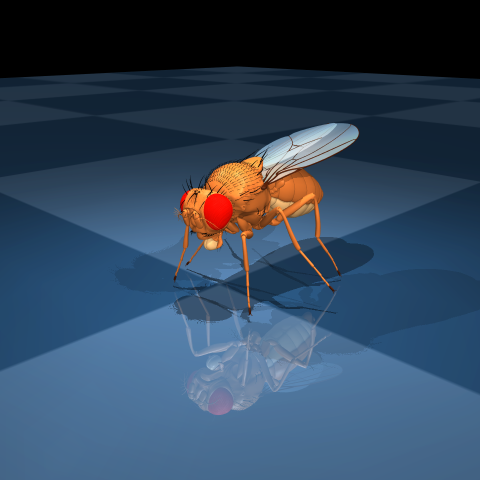

In [67]:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True

pixels = rollout_env.render(rollout2[20], camera='track1', width=480, height=480, scene_option=scene_option)
media.show_image(pixels)

In [68]:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True

pixels = rollout_env.render(rollout2, camera='track1', width=480, height=480, scene_option=scene_option)
media.show_video(pixels,fps=50)

In [21]:
from brax.training.acme import running_statistics
from custom_brax.custom_losses import PPONetworkParams
def create_mask():
    mask = {'params': {'encoder': 'encoder', 'decoder': 'decoder'}}
    value = {'params': 'encoder'}
    return PPONetworkParams(mask,value)


In [11]:
def create_mask():
    mask = {'params': {'encoder': 'encoder', 'decoder': 'decoder'}}
    value = {'params': 'encoder'}
    return PPONetworkParams(mask,value)


In [27]:

episode_length = (env_args.clip_length - 50 - env_args.ref_len) * env._steps_for_cur_frame
print(f"episode_length {episode_length}")


train_fn = functools.partial(
            ppo.train,
            num_envs=cfg.train["num_envs"],
            num_timesteps=100,
            num_evals=1,
            num_resets_per_eval=cfg.train['num_resets_per_eval'],
            reward_scaling=cfg.train['reward_scaling'],
            episode_length=episode_length,
            normalize_observations=True,
            action_repeat=cfg.train['action_repeat'],
            clipping_epsilon=cfg.train["clipping_epsilon"],
            unroll_length=cfg.train['unroll_length'],
            num_minibatches=cfg.train["num_minibatches"],
            num_updates_per_batch=cfg.train["num_updates_per_batch"],
            discounting=cfg.train['discounting'],
            learning_rate=cfg.train["learning_rate"],
            kl_weight=cfg.train["kl_weight"],
            entropy_cost=cfg.train['entropy_cost'],
            batch_size=cfg.train["batch_size"],
            seed=cfg.train['seed'],
            network_factory=functools.partial(
                custom_ppo_networks.make_encoderdecoder_ppo_networks,
                encoder_hidden_layer_sizes=cfg.train['encoder_hidden_layer_sizes'],
                decoder_hidden_layer_sizes=cfg.train['decoder_hidden_layer_sizes'],
                value_hidden_layer_sizes=cfg.train['value_hidden_layer_sizes'],
            ),
            restore_checkpoint_path=max_ckpt,
            freeze_fn = create_mask,
        )


episode_length 946


In [55]:
params[1].policy['params']['encoder']

{'params': {'decoder': {'LayerNorm_0': {'bias': Array([ 0.01731048, -0.00904714,  0.09407102, -0.02594654,  0.01593495,
            0.03715621,  0.00610518, -0.00967912,  0.02021122,  0.06619641,
            0.01199926,  0.01486713,  0.05610774,  0.01528364, -0.01477283,
            0.00311791, -0.02716998, -0.04215733,  0.01167444,  0.03843452,
           -0.03186993, -0.00058468,  0.0149497 , -0.03511928,  0.05585234,
            0.02927883,  0.048905  ,  0.02959033, -0.0074123 ,  0.00204154,
           -0.00644582, -0.02323694,  0.03025895,  0.02481595, -0.00344412,
            0.01790519, -0.01900788,  0.03540667, -0.03799602,  0.04787494,
           -0.00616974,  0.04134345, -0.01724523,  0.00967702, -0.0109723 ,
            0.02648342,  0.0207802 ,  0.07306565, -0.0298298 , -0.00095152,
            0.01424145, -0.02661853, -0.09939934,  0.01710664,  0.05070613,
           -0.05165924, -0.0133182 , -0.02271423, -0.03774946,  0.02539193,
            0.02962468,  0.02722426, -0.0109

In [15]:
import custom_brax.custom_losses as ppo_losses


In [26]:
network_factory=functools.partial(
                # custom_ppo_networks.make_intention_ppo_networks,
                custom_ppo_networks.make_encoderdecoder_ppo_networks,
                encoder_hidden_layer_sizes=cfg.train['encoder_hidden_layer_sizes'],
                decoder_hidden_layer_sizes=cfg.train['decoder_hidden_layer_sizes'],
                value_hidden_layer_sizes=cfg.train['value_hidden_layer_sizes'],
            )

normalize = lambda x, y: x

ppo_network = network_factory(
        state.obs.shape[-1],
        5,
        env.action_size,
        preprocess_observations_fn=normalize,
    )

In [31]:
init_params = ppo_losses.PPONetworkParams(
    policy=ppo_network.policy_network.init(rng),
    value=ppo_network.value_network.init(rng),
)

In [22]:
init_params.policy['params']['encoder']

{'hidden_0': {'kernel': Array([[ 0.5868452 , -0.4743108 , -0.5653391 , ...,  0.34651327,
           0.246423  , -0.5464664 ],
         [-0.6521018 ,  0.6345195 , -0.07838096, ...,  0.5168104 ,
           0.3124815 , -0.17869227],
         [-0.07024699,  0.4433011 , -0.5715655 , ...,  0.7282831 ,
           0.13873805,  0.65838903],
         [ 0.5081505 ,  0.17985278,  0.52154577, ..., -0.3119995 ,
           0.20252481, -0.45054638],
         [ 0.2406773 ,  0.5199413 , -0.6996059 , ...,  0.6365529 ,
          -0.5714238 ,  0.3969369 ]], dtype=float32),
  'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [ ]:
init_params.policy['params']

In [47]:
from flax.core import frozen_dict
from flax.core.frozen_dict import FrozenDict

def create_mask(params, label_fn):
    mask = {}
    def _map(params, mask, label_fn):
        for k in params:
            if not label_fn(k):
                mask[k] = False
            else:
                if isinstance(params[k], FrozenDict):
                    mask[k] = {}
                    _map(params[k], mask[k], label_fn)
                else:
                    mask[k] = True
    _map(params, mask, label_fn)
    return frozen_dict.freeze(mask)


def print_tree(d, depth, print_value=False):
    for k in d.keys():
        if isinstance(d[k], FrozenDict):
            print('  ' * depth, k)
            print_tree(d[k], depth + 1, print_value)
        else:
            if print_value:
                print('  ' * depth, k, d[k])
            else:
                print('  ' * depth, k)


def compare_params(lhs, rhs, depth):
    for k in lhs.keys():
        if isinstance(lhs[k], FrozenDict):
            print('  ' * depth, k)
            compare_params(lhs[k], rhs[k], depth + 1)
        else:
            print('  ' * depth, k, jp.mean(jp.abs(lhs[k] - rhs[k])))

In [37]:
def create_mask():
    mask = {'params': {'encoder': 'learned','bottleneck':'learned', 'decoder': 'frozen'}}
    value = {'params': 'learned'}
    return PPONetworkParams(mask,value)


# optimizer = optax.multi_transform({'encoder': optax.adam(learning_rate=1.0),'decoder': optax.set_to_zero()},
#                            create_mask())
optimizer = optax.multi_transform(
        {
            'learned': optax.adam(learning_rate=0.001), 
            'frozen': optax.set_to_zero()
            },
        # create_mask(),
        param_mask,
        )
optimizer.init(init_params)
# state = train_state.TrainState.create(apply_fn=model.apply,
#                                       params=params,
#                                       tx=tx)

PartitionState(inner_states={'learned': MaskedState(inner_state=(ScaleByAdamState(count=Array(0, dtype=int32), mu=PPONetworkParams(policy={'params': {'bottleneck': {'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'kernel': Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)}, 'decoder': MaskedNode(), 'encoder': {'LayerNorm_0': {'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [81]:
policy=ppo_network.policy_network.init(rng)
value=ppo_network.value_network.init(rng)

In [82]:
training_state = TrainingState(  # pytype: disable=wrong-arg-types  # jax-ndarray
    optimizer_state=optimizer.init(
        init_params
    ),  # pytype: disable=wrong-arg-types  # numpy-scalars
    params=init_params,
    normalizer_params=running_statistics.init_state(
        specs.Array(env_state.obs.shape[-1:], jnp.dtype("float32"))
    ),
    env_steps=0,
)



PartitionState(inner_states={'encoder': MaskedState(inner_state=(ScaleByAdamState(count=Array(0, dtype=int32), mu=PPONetworkParams(policy={'params': {'encoder': {'LayerNorm_0': {'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [22]:

# def map_nested_fn(fn):
#     '''Recursively apply `fn` to key-value pairs of a nested dict.'''
#     def map_fn(nested_dict):
#         return {'set_zero': (map_fn(v) if (isinstance(v, dict) & k=='decoder') else fn('adam', v)) for k, v in nested_dict.items()}
    
    
# def map_nested_fn(fn):
#     '''Recursively apply `fn` to Parameters to freeze.'''
#     def map_fn(nested_val):
#         if isinstance(nested_val, dict):
#             return {k: (map_fn(v) if (if isinstance(nested_val, dict)) fn('set_zero',v) elif k=='decoder' else fn('adam', v)) for k, v in nested_val.items()}
#     return map_fn



def construct_key_value_pairs(fn):
    def map_func(leaf):
        if isinstance(leaf,dict):
            for k,v in leaf.items():
                return map_func(v)
        else:
            if leaf == 'decoder':
                return fn('decoder',leaf)
            else:
                return fn('adam',leaf)
    return map_func
label_fn = construct_key_value_pairs(lambda k,_: k )

optimizer = optax.multi_transform(
                    {
                     'adam': optax.adam(cfg.train["learning_rate"]), 
                     'set_zero': optax.set_to_zero()
                     },
                    label_fn
                    )

opt_state = optimizer.init(params[1].__dict__)



PartitionState(inner_states={'adam': MaskedState(inner_state=(ScaleByAdamState(count=Array(0, dtype=int32), mu={'policy': {'params': {'decoder': {'LayerNorm_0': {'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
     

In [124]:
optimizer = optax.multi_transform(
                    {
                     'adam': optax.adam(cfg.train["learning_rate"]), 
                     'decoder': optax.set_to_zero()
                     },
                    label_fn
                    )

opt_state = optimizer.init(params)

In [ ]:
opt_state

In [212]:
optimizer = optax.adam(learning_rate=cfg.train['learning_rate'])
opt_state = optimizer.init(params[:2])

In [213]:
opt_state

(ScaleByAdamState(count=Array(0, dtype=int32), mu=(RunningStatisticsState(mean=Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), std=Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), count=Array(0., dtype=float32), summed_variance=Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)), PPONetworkParams(policy={'params': {'decoder': {'LayerNorm_0': {'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.